# Final project: DEQ implementation

This is an attempt to implement (pretty dummy) DEQ models based on the `needle` framework.
Things that were implemented are:
- `all()` and `any()` support both in `cpu` and `cuda` backensd (without reduction for now). These were needed to define `__bool__` in `needle.array` that was used in `solver` functionality (i.e. comparing norms with thresholds)
- `FixedPoint` operation that encapsulates implicit layer functionality.
- `ModuleOp` operation which is aimed to map any `needle.nn.Module` to `needle.ops.TensorOp`. This allows to use modules in `FixedPoint`
- `BaseSolver` interface and `ForwardIteration` algorithm implementation for finding fixed points.
- Two models: `tanh(linear(Z) + X)` and ResNet-ish dummy DEQ

In this notebook we're testing aforementioned DEQ models on CIFAR-10.
Source code could be found here: https://github.com/LiableFish/dlsyscourse-project

## Set up environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714
%cd /content/drive/MyDrive/10714
!git clone https://github.com/LiableFish/dlsyscourse-project.git
%cd /content/drive/MyDrive/10714/dlsyscourse-project

!pip3 install --upgrade --no-deps git+https://github.com/dlsys10714/mugrade.git
!pip3 install pybind11
!pip3 install tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714
fatal: destination path 'dlsyscourse-project' already exists and is not an empty directory.
/content/drive/MyDrive/10714/dlsyscourse-project
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/dlsys10714/mugrade.git to /tmp/pip-req-build-tb2l20jq
  Running command git clone --filter=blob:none --quiet https://github.com/dlsys10714/mugrade.git /tmp/pip-req-build-tb2l20jq
  Resolved https://github.com/dlsys10714/mugrade.git to commit 98609ee80ee24bf278455b48aa8d06bd3f5d0430
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!make

-- Found pybind11: /home/liablefish/dlsyscourse-project/.venv/lib/python3.7/site-packages/pybind11/include (found version "2.10.3")
-- Found cuda, building cuda backend
Wed Jan  4 18:45:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    30W /  70W |      0MiB / 15360MiB |     10%      Default |
|                               |                      |                  N/A |

In [2]:
# Download the datasets you will be using for this assignment

import urllib.request
import os

!mkdir -p './data/ptb'
# Download Penn Treebank dataset
ptb_data = "https://raw.githubusercontent.com/wojzaremba/lstm/master/data/ptb."
for f in ['train.txt', 'test.txt', 'valid.txt']:
    if not os.path.exists(os.path.join('./data/ptb', f)):
        urllib.request.urlretrieve(ptb_data + f, os.path.join('./data/ptb', f))

# Download CIFAR-10 dataset
if not os.path.isdir("./data/cifar-10-batches-py"):
    urllib.request.urlretrieve("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz", "./data/cifar-10-python.tar.gz")
    !tar -xvzf './data/cifar-10-python.tar.gz' -C './data'

In [2]:
import sys
sys.path.append('./python')
sys.path.append('./apps')

In [3]:
import numpy as np

In [4]:
import needle as ndl

### Unit testing

In [5]:
!pytest tests/test_fixed_point.py

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.2.0, pluggy-1.0.0
rootdir: /home/liablefish/dlsyscourse-project
plugins: anyio-3.6.2
collected 14 items                                                             

tests/test_fixed_point.py ..............                                 [100%]

=============================== warnings summary ===============================
tests/test_fixed_point.py:66
  /home/liablefish/dlsyscourse-project/tests/test_fixed_point.py:66: PytestCollectionWarning: cannot collect test class 'TestModule' because it has a __init__ constructor (from: tests/test_fixed_point.py)
    class TestModule(nn.Module):

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
======================== 14 passed, 1 warning in 1.82s =========================


In [6]:
!pytest tests/test_nd_backend.py -k "any or all"

============================= test session starts ==============================
platform linux -- Python 3.7.12, pytest-7.2.0, pluggy-1.0.0
rootdir: /home/liablefish/dlsyscourse-project
plugins: anyio-3.6.2
collected 154 items / 130 deselected / 24 selected                             

tests/test_nd_backend.py ........................                        [100%]

====================== 24 passed, 130 deselected in 2.92s ======================


### Define dataloaders and train util

In [7]:
device = ndl.cuda()

In [8]:
train_dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=True)
test_dataset = ndl.data.CIFAR10Dataset("data/cifar-10-batches-py", train=False)

In [9]:
train_dataloader = ndl.data.DataLoader(
         dataset=train_dataset,
         batch_size=128,
         shuffle=True,
)

test_dataloader = ndl.data.DataLoader(
         dataset=test_dataset,
         batch_size=128,
         shuffle=False,
)

In [10]:
X, _ = next(iter(train_dataloader))
X = ndl.Tensor(X, device=device)

In [11]:
from simple_training import train_cifar10, evaluate_cifar10

In [12]:
def _train(model, n_epochs: int = 10, batch_size: int = 128):
    train_dataloader = ndl.data.DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
    )

    test_dataloader = ndl.data.DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            shuffle=False,
    )
    train_cifar10(
        model,
        train_dataloader,
        n_epochs=n_epochs,
        optimizer=ndl.optim.Adam,
        lr=0.001, 
        weight_decay=0.001,
    )
    evaluate_cifar10(model, test_dataloader)

## Training "tanh" model

In [13]:
from models import TanhLinearDEQ

In [14]:
tanh_model = TanhLinearDEQ(
    in_features=3072,
    hidden_size=128,
    n_classes=10,
    device=device,
    use_deq=False,
    depth=100,
)

In [15]:
tanh_deq_model = TanhLinearDEQ(
    in_features=3072,
    hidden_size=128,
    n_classes=10,
    device=device,
    use_deq=True,
    solver=ndl.solver.ForwardIteration(max_iter=100, debug=True),
)

In [16]:
len(tanh_model.parameters())

104

In [17]:
sum(np.prod(p.shape) for p in tanh_model.parameters())

2033034

In [18]:
len(tanh_deq_model.parameters())

5

In [19]:
sum(np.prod(p.shape) for p in tanh_deq_model.parameters())

411018

We see that DEQ version allocates ~5 times fewer parameters that "stacking more layers/old school" version.

In [20]:
%%time
tanh_model(X).shape

CPU times: user 5.05 ms, sys: 6.24 ms, total: 11.3 ms
Wall time: 11 ms


(128, 10)

In [21]:
%%time
tanh_deq_model(X).shape

CPU times: user 149 ms, sys: 91.6 ms, total: 241 ms
Wall time: 239 ms


(128, 10)

In [22]:
_train(tanh_model, batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.29756 loss: [1.9734181] time: 28.076s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.36752 loss: [1.776062] time: 27.142s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.39468 loss: [1.7005783] time: 28.019s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.41522 loss: [1.645514] time: 27.460s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.42608 loss: [1.6161754] time: 27.062s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.43598 loss: [1.58207] time: 26.808s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.44118 loss: [1.5649003] time: 26.135s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.44922 loss: [1.5486219] time: 27.723s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 8/9 accuracy: 0.45518 loss: [1.5292084] time: 25.980s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 9/9 accuracy: 0.46052 loss: [1.5119567] time: 27.031s


  0%|          | 0/39 [00:00<?, ?it/s]

accuracy: 0.4456 loss: [1.5401795]


In [23]:
_train(tanh_deq_model,  batch_size=256)

  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.29082 loss: [1.9968189] time: 19.220s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.36644 loss: [1.7920492] time: 17.885s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.38792 loss: [1.7271742] time: 18.450s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.4046 loss: [1.6826488] time: 17.865s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.4163 loss: [1.6494112] time: 17.603s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.42652 loss: [1.6162156] time: 18.057s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.43288 loss: [1.5958008] time: 17.857s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.4355 loss: [1.5830908] time: 18.132s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 8/9 accuracy: 0.44434 loss: [1.5627037] time: 18.408s


  0%|          | 0/195 [00:00<?, ?it/s]

Epoch 9/9 accuracy: 0.44716 loss: [1.5519847] time: 18.963s


  0%|          | 0/39 [00:00<?, ?it/s]

accuracy: 0.4406 loss: [1.5759534]


Hooray! Loss goes down accuracy goes up and performance are comparable with "old school" method.

Let's look at some "fixed point solver" statistics.

In [24]:
import matplotlib.pyplot as plt

In [25]:
history = tanh_deq_model.deq.fixed_op.history

In [26]:
import numpy as np
np.array([meta.n_iter for meta in history]).mean()

9.34832583708146

Text(0, 0.5, 'n_iter')

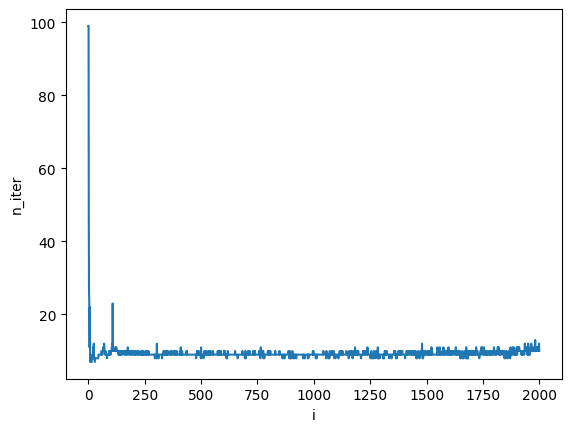

In [27]:
plt.plot(range(len(history)), [meta.n_iter for meta in history])
plt.xlabel("i")
plt.ylabel("n_iter")

Text(0, 0.5, 'mean norm')

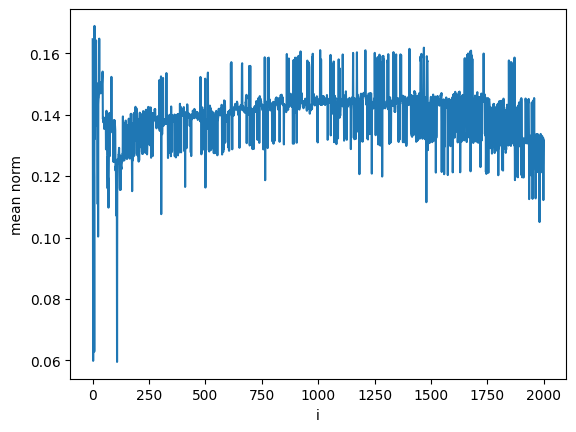

In [28]:
plt.plot(range(len(history)), [np.mean(meta.norms) for meta in history])
plt.xlabel("i")
plt.ylabel("mean norm")

We can see that from some point during training the solver started to converge and mean diff norm between iterations stabilised. Training required ~10 solver iterations on average which is 10 times less than number of layers in "old school" version.

## Training "ResNet" model

In [13]:
from models import ResNetDEQ

In [14]:
resnet_model = ResNetDEQ(
    in_channels=3,
    out_channels=16,
    kernel_size=3,
    n_classes=10,
    device=device,
    use_deq=False,
    depth=50,
)

In [15]:
resnet_deq_model = ResNetDEQ(
    in_channels=3,
    out_channels=16,
    kernel_size=3,
    n_classes=10,
    device=device,
    use_deq=True,
    solver=ndl.solver.ForwardIteration(max_iter=100, debug=True),
)

In [16]:
len(resnet_model.parameters())

156

In [17]:
sum(np.prod(p.shape) for p in resnet_model.parameters())

127530

In [18]:
len(resnet_deq_model.parameters())

9

In [19]:
sum(np.prod(p.shape) for p in resnet_deq_model.parameters())

13066

This time ~10 times fewer parameters for DEQ version...a

In [20]:
%%time
resnet_model(X).shape

CPU times: user 171 ms, sys: 135 ms, total: 307 ms
Wall time: 378 ms


(128, 10)

In [21]:
%%time
resnet_deq_model(X).shape

CPU times: user 1.13 s, sys: 622 ms, total: 1.75 s
Wall time: 1.8 s


(128, 10)

... but compute time is much longer.

In [28]:
_train(resnet_model, batch_size=128)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.38652 loss: [1.7273397] time: 375.485s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.49084 loss: [1.4132915] time: 373.384s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.53232 loss: [1.3010283] time: 368.851s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.56052 loss: [1.2215405] time: 365.945s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.58626 loss: [1.1585852] time: 365.851s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.60502 loss: [1.1042218] time: 366.012s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.62238 loss: [1.0614237] time: 365.734s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.63382 loss: [1.024022] time: 365.286s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8/9 accuracy: 0.64658 loss: [0.9906909] time: 364.764s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9/9 accuracy: 0.66022 loss: [0.9578912] time: 364.495s


  0%|          | 0/78 [00:00<?, ?it/s]

accuracy: 0.4754 loss: [1.6831284]


In [22]:
_train(resnet_deq_model, batch_size=128)

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0/9 accuracy: 0.32306 loss: [1.9316163] time: 2093.776s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/9 accuracy: 0.39984 loss: [1.7128916] time: 2091.887s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/9 accuracy: 0.40936 loss: [1.6819409] time: 2091.225s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 3/9 accuracy: 0.4301 loss: [1.6204581] time: 2092.294s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 4/9 accuracy: 0.4413 loss: [1.5891842] time: 2090.029s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 5/9 accuracy: 0.44794 loss: [1.5681999] time: 2089.593s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 6/9 accuracy: 0.45452 loss: [1.5525784] time: 2090.209s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 7/9 accuracy: 0.45802 loss: [1.5405239] time: 2090.482s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 8/9 accuracy: 0.46096 loss: [1.5305728] time: 2095.846s


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch 9/9 accuracy: 0.46444 loss: [1.523169] time: 2094.332s


  0%|          | 0/78 [00:00<?, ?it/s]

accuracy: 0.4463 loss: [1.5705509]


Okay, training loss and accuracy are much worse for the DEQ version, but, for whatever reason, validation performance more or less comparable ¯\_(ツ)_/¯ ("old school" model overfits due to too large number of stacked layers?)

Let's look at solver statistics

In [23]:
import matplotlib.pyplot as plt

In [24]:
history = resnet_deq_model.deq.fixed_op.history

In [25]:
import numpy as np
np.array([meta.n_iter for meta in history]).mean()

99.0

Text(0, 0.5, 'n_iter')

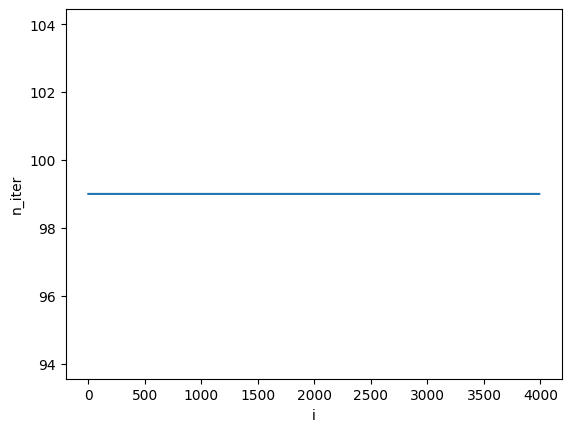

In [29]:
plt.plot(range(len(history)), [meta.n_iter for meta in history])
plt.xlabel("i")
plt.ylabel("n_iter")

Text(0, 0.5, 'mean norm')

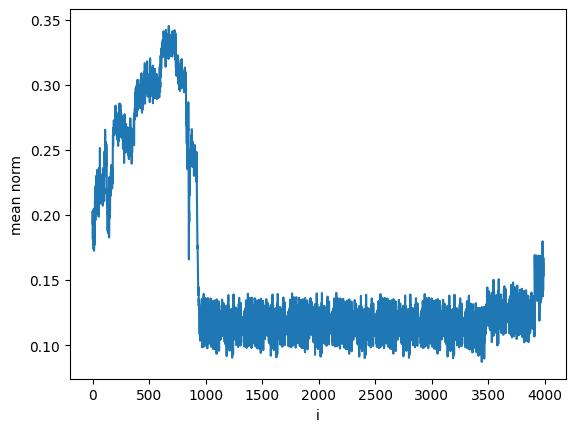

In [27]:
plt.plot(range(len(history)), [np.mean(meta.norms) for meta in history])
plt.xlabel("i")
plt.ylabel("mean norm")

Solver definitely failed to converge that likely explaind poor performance. But mean norm had dropped and stabilised that likely explains why the model were still able to learn (training loss was decreasing)

# Conclusion

With a lot of mind work and not so many lines of code we (more or less) succeeded in implementing dummy DEQ models and auto differentiation support. There is still plenty work to do e.g. more efficient solver algorithms or different DEQ architectures, but let's keep it for another course :)